# Timing Effect & Interaction Analysis (Quasi-experimental robustness check)

## Executive Summary

This analysis evaluates whether the conversion advantage of cellular contact over telephone is consistent across months or concentrated in specific periods. 

Using logistic regression with robust standard errors, we estimate:
1. The average adjusted effect of contact method.
2. A month-level interaction model to assess timing heterogeneity.

Results indicate:
- No statistically significant average advantage of cellular contact.
- Substantial month-level variation in odds ratios.
- Only a limited number of months show statistically distinguishable channel effects.

Overall, the cellular channel does not demonstrate uniform dominance across months. The effect appears time-sensitive rather than structurally persistent.

## 1. Purpose of the Analysis

The dataset contains a month variable without year separation. 
Therefore, a true Difference-in-Differences design cannot be implemented.

Instead, we use a contact × month interaction model as a robustness check to examine:

- Whether the cellular channel maintains a consistent advantage.
- Or whether its effect varies across months.

This analysis focuses on timing heterogeneity rather than causal policy inference.

In [55]:
# Call Libraries
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [56]:
# Load data
df = pd.read_csv('../data/preprocessed-bank-data.csv')

df.info()
df.head(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [57]:
# Set the category: Make telephone as baseline
df['contact'] = pd.Categorical(df['contact'], categories=['telephone', 'cellular'])
df['month'] = pd.Categorical(df['month'])

## 2. Model Specification

### 2.1 Baseline Adjusted Model

#### Model
`conversion ~ contact + controls` (excluding macro variables)

Macro variables are excluded due to high collinearity with month.

In [58]:
# Control without macro controls
# Macro variables such as emp.var.rate, euribor3m are duplicate information of month, so we exclude them
# to prevent multicollinearity and to focus on the timing effect of contact method
controls_no_macro = [
    'age',
    'campaign',
    'pdays',
    'previous',

    'C(job)',
    'C(marital)',
    'C(education)',
    'C(default)',
    'C(housing)',
    'C(loan)',
    'C(day_of_week)',
    'C(poutcome)']

In [59]:
# Baseline Adjusted Model
f_base = 'y ~ C(contact) +' + '+'.join(controls_no_macro)

m_base = smf.glm(
    formula = f_base,
    data = df,
    family = sm.families.Binomial()
).fit(cov_type='HC1') # Robust standard errors

m_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                41188
Model:                            GLM   Df Residuals:                    41150
Model Family:                Binomial   Df Model:                           37
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12532.
Date:                Sat, 28 Feb 2026   Deviance:                       25063.
Time:                        15:20:20   Pearson chi2:                 4.20e+04
No. Iterations:                    20   Pseudo R-squ. (CS):            0.09112
Covariance Type:                  HC1                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -1.7298    218.516     -0.008      0.994    -430.013     426.554
C(contact)[T.cellular]                  0.8052     67.530      0.012      0.990    -131.552     133.162
C(job)[T.blue-collar]                  -0.2737     19.224     -0.014      0.989     -37.951      37.404
C(job)[T.entrepreneur]                 -0.2330      8.579     -0.027      0.978     -17.048      16.581
C(job)[T.housemaid]                    -0.1245    112.163     -0.001      0.999    -219.959     219.710
C(job)[T.management]                   -0.1413      4.791     -0.029      0.976      -9.531       9.248
C(job)[T.retired]                       0.6306     31.111      0.020      0.984     -60.346      61.607
C(job)[T.self-employed]                -0.0723     14.775     -0.005      0.996     -29.031      28.886
C(job)[T.services]                     -0.2155      5.355     -0.040      0.968     -10.711      10.280
C(job)[T.student]                       0.8215      4.847      0.169      0.865      -8.678      10.321
C(job)[T.technician]                   -0.1496     18.156     -0.008      0.993     -35.735      35.436
C(job)[T.unemployed]                    0.1709     20.474      0.008      0.993     -39.958      40.300
C(job)[T.unknown]                      -0.0739     82.358     -0.001      0.999    -161.493     161.345
C(marital)[T.married]                   0.0900      6.776      0.013      0.989     -13.191      13.371
C(marital)[T.single]                    0.2957      3.599      0.082      0.935      -6.758       7.349
C(marital)[T.unknown]                   0.2959     26.121      0.011      0.991     -50.900      51.492
C(education)[T.basic.6y]                0.0384     22.034      0.002      0.999     -43.146      43.223
C(education)[T.basic.9y]               -0.1242     19.200     -0.006      0.995     -37.756      37.508
C(education)[T.high.school]            -0.0325     30.557     -0.001      0.999     -59.922      59.857
C(education)[T.illiterate]              0.7932    164.363      0.005      0.996    -321.352     322.939
C(education)[T.professional.course]     0.0255     13.126      0.002      0.998     -25.700      25.751
C(education)[T.university.degree]       0.1123     36.103      0.003      0.998     -70.648      70.873
C(education)[T.unknown]                 0.2151     31.286      0.007      0.995     -61.105      61.535
C(default)[T.unknown]                  -0.6706      6.195     -0.108      0.914     -12.813      11.472
C(default)[T.yes]                     -19.7225   1.59e+12  -1.24e-11      1.000   -3.12e+12    3.12e+12
C(housing)[T.unknown]                   0.0016   8.45e+18   1.94e-22      1.000   -1.66e+19    1.66e+19
C(housing)[T.yes]                      -0.0084      0.160     -0.05

In [60]:
b = m_base.params.get('C(contact)[T.cellular]', np.nan)
se = m_base.bse.get('C(contact)[T.cellular]', np.nan)

or_ = np.exp(b)
ci_low = np.exp(b-1.96 * se)
ci_high = np.exp(b+1.96 * se)

pd.DataFrame([{
    'term': 'cellular vs telephone (Average)',
    'Odds Ratio': or_,
    'CI Lower': ci_low,
    'CI Upper': ci_high
}])

,term,Odds Ratio,CI Lower,CI Upper
0,cellular vs telephone (Average),2.237099,7.355156e-58,6.804221e+57


#### Result
The adjusted average effect of cellular contact (vs telephone) is not statistically significant.

Although the point estimate suggests higher odds under cellular contact (OR ≈ 2.24), the 95% confidence interval is extremely wide and includes 1.

#### Interpretation
There is no statistically reliable evidence of an overall cellular advantage.

### 2.2 Timing Heterogeneity Model

#### Model
`conversion ~ contact × month + controls`

This model allows the contact effect to vary by month.

The interaction terms reveal substantial variation across months. Some months show elevated odds ratios for cellular contact, while others show no meaningful difference.

This suggests that channel effectiveness is time-dependent rather than constant.

In [61]:
# Timing heterogeneity model (contact x month interaction)

f_time = 'y ~ C(contact) * C(month) + ' + '+'.join(controls_no_macro)

m_time = smf.glm(
    formula = f_time,
    data = df,
    family = sm.families.Binomial()
).fit(cov_type='HC1') # Robust standard errors

m_time.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                41188
Model:                            GLM   Df Residuals:                    41132
Model Family:                Binomial   Df Model:                           55
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11925.
Date:                Sat, 28 Feb 2026   Deviance:                       23851.
Time:                        15:20:22   Pearson chi2:                 4.18e+04
No. Iterations:                    20   Pseudo R-squ. (CS):             0.1175
Covariance Type:                  HC1                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -0.2715        nan        nan        nan         nan         nan
C(contact)[T.cellular]                    -0.1959      0.514     -0.381      0.703      -1.203       0.811
C(month)[T.aug]                           -0.8793      0.403     -2.180      0.029      -1.670      -0.089
C(month)[T.dec]                            0.2264      1.368      0.165      0.869      -2.456       2.908
C(month)[T.jul]                           -1.5110      0.257     -5.877      0.000      -2.015      -1.007
C(month)[T.jun]                           -1.5529      0.463     -3.352      0.001      -2.461      -0.645
C(month)[T.mar]                            0.4219      0.226      1.869      0.062      -0.021       0.864
C(month)[T.may]                           -1.9599      0.173    -11.337      0.000      -2.299      -1.621
C(month)[T.nov]                           -0.9018      0.217     -4.155      0.000      -1.327      -0.476
C(month)[T.oct]                            0.5903      0.139      4.243      0.000       0.318       0.863
C(month)[T.sep]                           -0.7039      0.230     -3.062      0.002      -1.154      -0.253
C(job)[T.blue-collar]                     -0.2222      0.178     -1.251      0.211      -0.570       0.126
C(job)[T.entrepreneur]                    -0.1692      0.082     -2.067      0.039      -0.330      -0.009
C(job)[T.housemaid]                       -0.0972      0.128     -0.757      0.449      -0.349       0.154
C(job)[T.management]                      -0.1152      0.088     -1.306      0.191      -0.288       0.058
C(job)[T.retired]                          0.4568      0.172      2.662      0.008       0.120       0.793
C(job)[T.self-employed]                   -0.1135      0.106     -1.067      0.286      -0.322       0.095
C(job)[T.services]                        -0.1816      0.075     -2.416      0.016      -0.329      -0.034
C(job)[T.student]                          0.5655      0.106      5.322      0.000       0.357       0.774
C(job)[T.technician]                      -0.1147      0.134     -0.856      0.392      -0.377       0.148
C(job)[T.unemployed]                       0.0568      0.155      0.366      0.714      -0.247       0.361
C(job)[T.unknown]                         -0.1702      0.677     -0.251      0.801      -1.497       1.157
C(marital)[T.married]                      0.0707      0.037      1.891      0.059      -0.003       0.144
C(marital)[T.single]                       0.1935      0.123      1.572      0.116      -0.048       0.435
C(marital)[T.unknown]                      0.2436      0.778      0.313      0.754      -1.282       1.769
C(education)[T.basic.6y]                   0.0877      0.050      1.767      0.077     

## 3. Monthly Odds Ratio Interpretation

### 3.1 Monthly Channel Comparison

In [62]:
params = m_time.params
cov = m_time.cov_params()

months = list(df['month'].cat.categories)
base_month = months[0] # Baseline month that starts with no interaction term (contact effect only)

def month_or_ci(month_label: str):
    # base_contact
    c_name = 'C(contact)[T.cellular]'
    b_c = params.get(c_name, 0.0)

    # beta_interaction for this month (if it's the baseline month, this will be 0)
    inter_name = f'C(contact)[T.cellular]:C(month)[T.{month_label}]'
    b_inter = params.get(inter_name, 0.0)

    b = b_c + b_inter

    # var(b) = var(beta_contact) + var(beta_interaction) + 2*cov(beta_contact, beta_interaction)
    v = cov.loc[c_name, c_name]
    if inter_name in cov.index:
        v += cov.loc[inter_name, inter_name] + 2 * cov.loc[c_name, inter_name]

    se = np.sqrt(v)

    or_ = np.exp(b)
    ci_low = np.exp(b - 1.96 * se)
    ci_high = np.exp(b + 1.96 * se)

    return or_, ci_low, ci_high

rows  = []
for month in months:
    or_, ci_low, ci_high = month_or_ci(month)
    rows.append({
        'term': f'cellular vs telephone ({month})',
        'month': month,
        'Odds Ratio cellular vs telephone': or_,
        'CI Lower': ci_low,
        'CI Upper': ci_high
    })

or_table = pd.DataFrame(rows).sort_values('month')
month_orders = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
or_table['month'] = pd.Categorical(or_table['month'], categories=month_orders, ordered=True)
or_table = or_table.sort_values('month')
or_table

/var/folders/tr/5gglss352kxc5bdk9wsgsk7c0000gn/T/ipykernel_85080/1127276205.py:23: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(v)


,term,month,Odds Ratio cellular vs telephone,CI Lower,CI Upper
5,cellular vs telephone (mar),mar,1.747681,0.523284,5.836963
0,cellular vs telephone (apr),apr,0.822055,0.300224,2.250900
6,cellular vs telephone (may),may,3.031727,NaN,NaN
4,cellular vs telephone (jun),jun,7.999537,3.135110,20.411592
3,cellular vs telephone (jul),jul,1.831328,0.724001,4.632257
1,cellular vs telephone (aug),aug,0.871760,0.285293,2.663812
9,cellular vs telephone (sep),sep,3.116992,0.987216,9.841456
8,cellular vs telephone (oct),oct,0.771529,0.278439,2.137836
7,cellular vs telephone (nov),nov,0.799757,0.375374,1.703931
2,cellular vs telephone (dec),dec,1.549555,0.408797,5.873629


In [63]:
or_table['OR_greater_1'] = or_table['Odds Ratio cellular vs telephone'] > 1
or_table['CI_excludes_1'] = (or_table['CI Lower']>1) | (or_table['CI Upper']<1)

share_or_gt_1 = or_table['OR_greater_1'].mean() *100
count_ci_excl = or_table['CI_excludes_1'].sum()

share_or_gt_1, int(count_ci_excl)

(np.float64(60.0), 1)

While cellular contact shows higher point estimates in 60% of months, this proportion is sensitive to model specification and does not imply statistical dominance.

Most confidence intervals overlap 1, indicating that monthly differences are not consistently distinguishable from zero.

In May, the interaction variance could not be reliably estimated,suggesting potential instability due to sparse cross-cell observations.

### 3.2 Visualisation Interpretation

The monthly OR plot illustrates substantial variability across months.

#### Key observations:
- Certain months (e.g., June) show elevated point estimates.
- Confidence bands are wide in several months.
- Most confidence intervals overlap the neutral line (OR = 1).

This visual pattern reinforces the statistical conclusion:
Channel effects fluctuate over time and lack consistent significance.

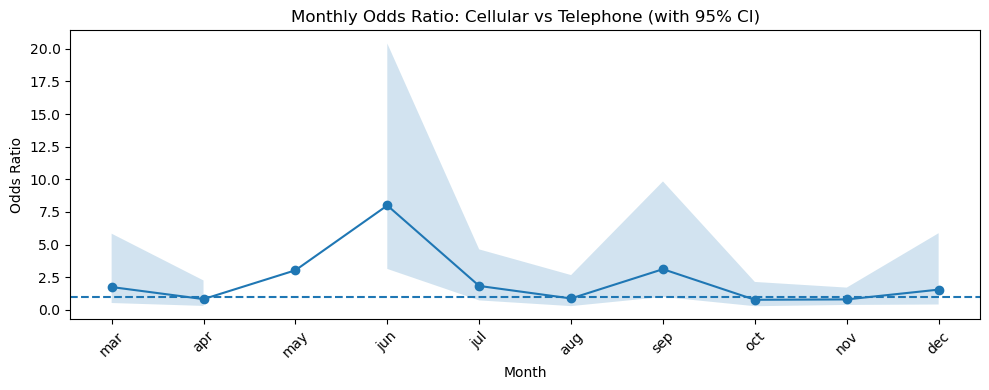

In [64]:
plt.figure(figsize=(10, 4))
plt.plot(or_table['month'], or_table['Odds Ratio cellular vs telephone'], marker = 'o')
plt.fill_between(
    or_table['month'],
    or_table['CI Lower'],
    or_table['CI Upper'],
    alpha=.2
)

plt.axhline(1, linestyle = '--')
plt.title('Monthly Odds Ratio: Cellular vs Telephone (with 95% CI)')
plt.ylabel('Odds Ratio')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.3 Conclusion

This analysis does not find statistically reliable evidence of an overall cellular advantage.

While cellular contact often shows higher estimated odds in specific months, these differences are not consistently statistically significant.

The results suggest:
- Channel effectiveness may be sensitive to timing.
- There is no stable structural dominance of cellular over telephone.

From a business perspective, channel strategy should not assume uniform superiority of one contact method across all periods.

## 4. Limitations

1. The absence of year indexing prevents separation of seasonality from macro timing effects.
2. Observational data limits causal interpretation.
3. Some categorical variables contain rare categories, potentially inflating standard errors.
4. Interaction estimates may be unstable in months with small sample sizes.